In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# --- 1. EXPLORATORY DATA ANALYSIS (NASA DATA) ---

# Define column names for the NASA dataset
column_names = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]

# Load the training data from the text file
# Make sure 'train_FD001.txt' is inside a 'data' subfolder
try:
    train_df = pd.read_csv('data/train_FD001.txt', sep=' ', header=None, names=column_names, index_col=False)
    # The last two columns are often empty due to trailing spaces, so we drop them
    train_df = train_df.drop(columns=[26, 27]) if 26 in train_df.columns else train_df
    print("NASA training data loaded successfully.")
    print(train_df.head())
except FileNotFoundError:
    print("ERROR: 'data/train_FD001.txt' not found. Please ensure the file is in the correct directory.")

NASA training data loaded successfully.
   unit_number  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
0            1               1       -0.0007       -0.0004         100.0   
1            1               2        0.0019       -0.0003         100.0   
2            1               3       -0.0043        0.0003         100.0   
3            1               4        0.0007        0.0000         100.0   
4            1               5       -0.0019       -0.0002         100.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  \
0    518.67    641.82   1589.70   1400.60     14.62  ...     521.66   
1    518.67    642.15   1591.82   1403.14     14.62  ...     522.28   
2    518.67    642.35   1587.99   1404.20     14.62  ...     522.42   
3    518.67    642.35   1582.79   1401.87     14.62  ...     522.86   
4    518.67    642.37   1582.85   1406.22     14.62  ...     522.19   

   sensor_13  sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  \
0    

C:\Users\USER\AppData\Local\Temp\ipykernel_27560\1193363008.py:17: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  train_df = pd.read_csv('data/train_FD001.txt', sep=' ', header=None, names=column_names, index_col=False)


Plotting sensor data for the first 5 engines...


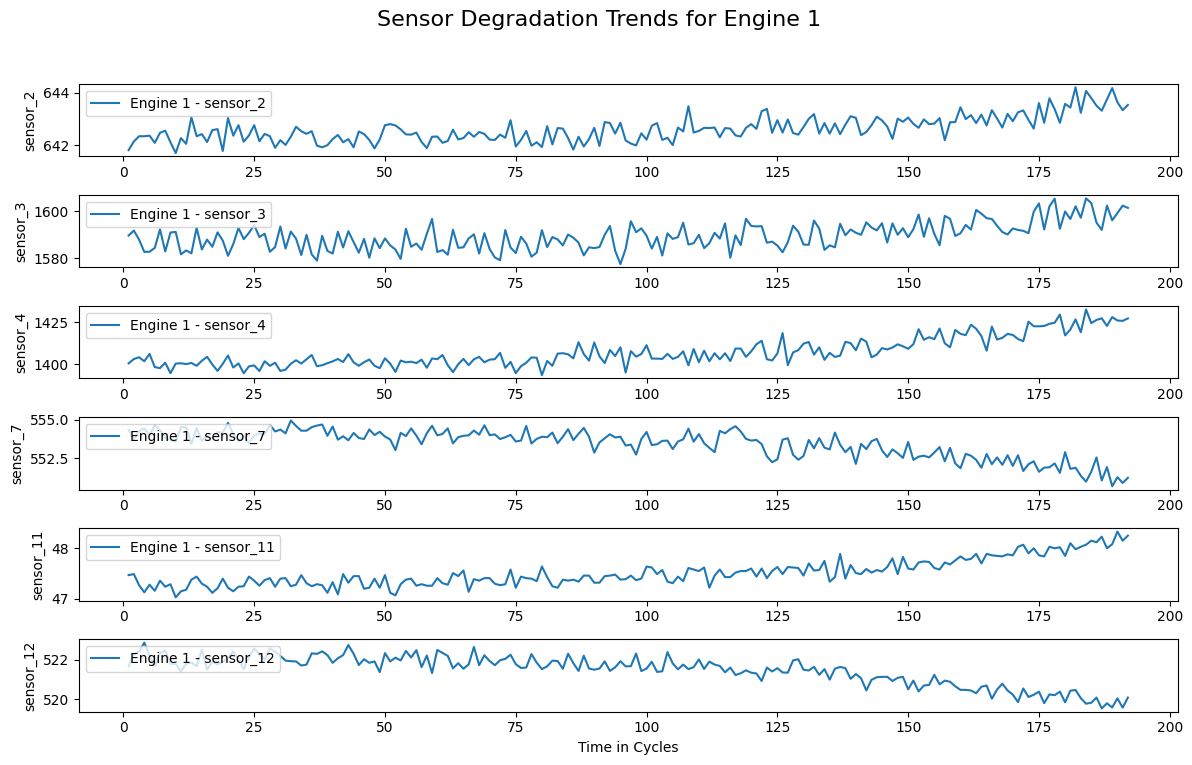

In [24]:
# --- Plotting sensor data for a few engines to observe trends ---
print("Plotting sensor data for the first 5 engines...")

# Select a few sensors that are known to be informative
sensors_to_plot = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_11', 'sensor_12']
num_sensors = len(sensors_to_plot)

# Create a plot for the first engine
engine_1_data = train_df[train_df['unit_number'] == 1]

plt.figure(figsize=(12, 8))
for i, sensor in enumerate(sensors_to_plot):
    plt.subplot(num_sensors, 1, i+1)
    plt.plot(engine_1_data['time_in_cycles'], engine_1_data[sensor], label=f'Engine 1 - {sensor}')
    plt.ylabel(sensor)
    plt.legend(loc='upper left')

plt.xlabel('Time in Cycles')
plt.suptitle('Sensor Degradation Trends for Engine 1', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [25]:
# --- Calculate RUL for each engine ---
print("Calculating RUL...")

# Find the maximum cycle for each engine (its failure point)
max_cycles = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycles']

# Merge the max cycles back into the original dataframe
train_df = pd.merge(train_df, max_cycles, on='unit_number', how='left')

# Calculate the RUL as the difference between max cycles and current cycles
train_df['RUL'] = train_df['max_cycles'] - train_df['time_in_cycles']

# Drop the 'max_cycles' column as it's intermediate and no longer needed
train_df = train_df.drop(columns=['max_cycles'])

print("RUL calculated and successfully added to the DataFrame.")
# Display the relevant columns to verify the calculation
print(train_df[['unit_number', 'time_in_cycles', 'RUL']].head())

Calculating RUL...
RUL calculated and successfully added to the DataFrame.
   unit_number  time_in_cycles  RUL
0            1               1  191
1            1               2  190
2            1               3  189
3            1               4  188
4            1               5  187



Loading and plotting CWRU Bearing Data...


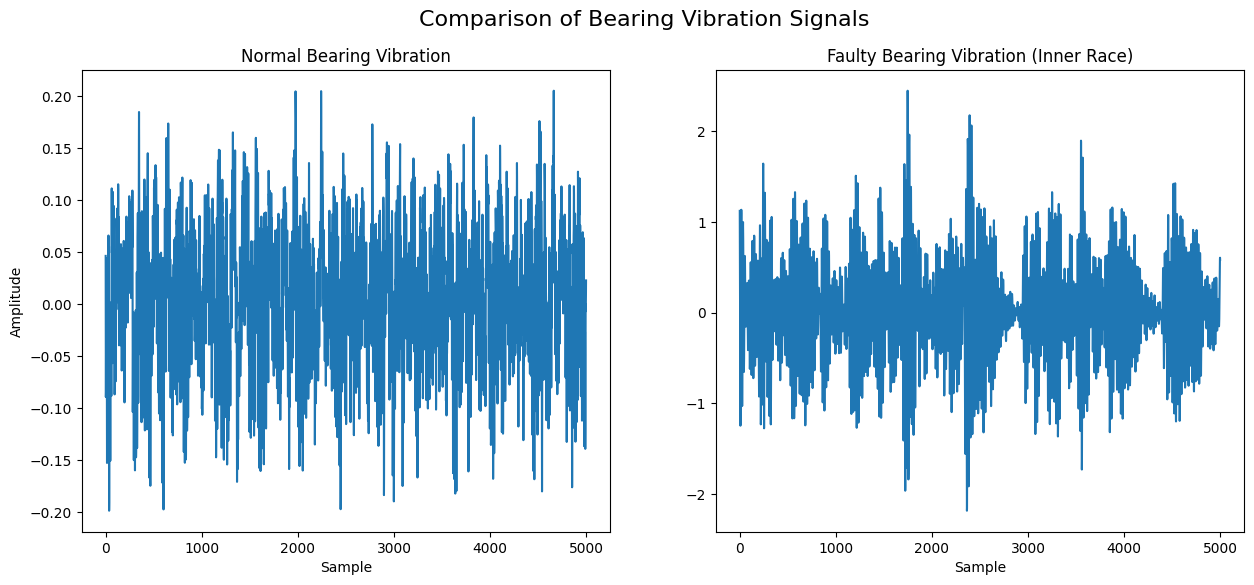

In [26]:
# --- Load and plot CWRU Bearing Data for visual comparison ---
print("\nLoading and plotting CWRU Bearing Data...")

try:
    # Load normal and faulty data from their respective .mat files
    normal_data_mat = loadmat('data/Time_Normal_1_098.mat')
    faulty_data_mat = loadmat('data/IR021_1_214.mat')

    # Extract the signal data (the key usually contains 'DE_time' for Drive End)
    normal_key = [key for key in normal_data_mat.keys() if 'DE_time' in key][0]
    faulty_key = [key for key in faulty_data_mat.keys() if 'DE_time' in key][0]
    normal_signal = normal_data_mat[normal_key].flatten()
    faulty_signal = faulty_data_mat[faulty_key].flatten()

    # Plot the signals for comparison
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(normal_signal[:5000]) # Plot first 5000 points for clarity
    plt.title('Normal Bearing Vibration')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    plt.subplot(1, 2, 2)
    plt.plot(faulty_signal[:5000])
    plt.title('Faulty Bearing Vibration (Inner Race)')
    plt.xlabel('Sample')
    
    plt.suptitle('Comparison of Bearing Vibration Signals', fontsize=16)
    plt.show()

except FileNotFoundError:
    print("ERROR: CWRU data files not found. Ensure 'Time_Normal_1_098.mat' and 'IR021_1_214.mat' are in the 'data' folder.")
except IndexError:
    print("ERROR: Could not find the required signal key (e.g., 'X098_DE_time') in the CWRU .mat files.")

In [27]:
# --- 2. INITIAL PREPROCESSING + SEQUENCE CREATION (Week-2 ready) ---

from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Columns to normalize (operational settings + sensors)
cols_to_normalize = ['op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]
scaler = MinMaxScaler()

# Apply the scaler to the selected columns
train_df[cols_to_normalize] = scaler.fit_transform(train_df[cols_to_normalize])
print("Sensor and operational setting data has been normalized.")

# --- Function to create sequences with unit IDs (needed for per-engine split) ---
def create_sequences_with_ids(df, sequence_length=30, feature_cols=cols_to_normalize):
    """
    Converts time-series data into sliding-window sequences and includes engine/unit IDs.
    """
    X_seq, y_seq, unit_ids = [], [], []
    for unit in df['unit_number'].unique():
        unit_data = df[df['unit_number']==unit][feature_cols].values
        unit_rul  = df[df['unit_number']==unit]['RUL'].values
        for i in range(len(unit_data) - sequence_length + 1):
            X_seq.append(unit_data[i:i+sequence_length])
            y_seq.append(unit_rul[i + sequence_length - 1])
            unit_ids.append(unit)
    return np.array(X_seq), np.array(y_seq), np.array(unit_ids)

# Create sequences
sequence_length = 30
X_all, y_all, seq_unit_ids = create_sequences_with_ids(train_df, sequence_length, cols_to_normalize)

print(f"\nCreated Week-2 sequences. Shape of X_all: {X_all.shape}, Shape of y_all: {y_all.shape}")


Sensor and operational setting data has been normalized.

Created Week-2 sequences. Shape of X_all: (17731, 30, 24), Shape of y_all: (17731,)


In [28]:
# --- 3. BUILD A BASELINE LINEAR REGRESSION MODEL (Week-2 ready) ---
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# --- 1. Per-engine train/val/test split ---
train_units = np.unique(seq_unit_ids)[:int(0.7*len(np.unique(seq_unit_ids)))]
val_units   = np.unique(seq_unit_ids)[int(0.7*len(np.unique(seq_unit_ids))):int(0.85*len(np.unique(seq_unit_ids)))]
test_units  = np.unique(seq_unit_ids)[int(0.85*len(np.unique(seq_unit_ids))):]

def split_by_units(X, y, unit_ids, selected_units):
    idx = np.isin(unit_ids, selected_units)
    return X[idx], y[idx]

X_train_seq, y_train_seq = split_by_units(X_all, y_all, seq_unit_ids, train_units)
X_val_seq,   y_val_seq   = split_by_units(X_all, y_all, seq_unit_ids, val_units)
X_test_seq,  y_test_seq  = split_by_units(X_all, y_all, seq_unit_ids, test_units)

# --- 2. Flatten sequences for 2D models ---
nsamples, nx, ny = X_train_seq.shape
X_train_2d = X_train_seq.reshape((nsamples, nx*ny))
X_val_2d   = X_val_seq.reshape((X_val_seq.shape[0], nx*ny))
X_test_2d  = X_test_seq.reshape((X_test_seq.shape[0], nx*ny))

print(f"Reshaped X_train from {X_train_seq.shape} to {X_train_2d.shape} for Linear Regression.")

# --- 3. Train baseline Linear Regression ---
lr_model = LinearRegression()
lr_model.fit(X_train_2d, y_train_seq)

# --- 4. Evaluate on training and test sets ---
y_pred_train = lr_model.predict(X_train_2d)
y_pred_test  = lr_model.predict(X_test_2d)

rmse_train = np.sqrt(mean_squared_error(y_train_seq, y_pred_train))
rmse_test  = np.sqrt(mean_squared_error(y_test_seq, y_pred_test))

print(f"\nBaseline Linear Regression Model Trained.")
print(f"RMSE on Training Data: {rmse_train:.2f}")
print(f"RMSE on Test Data:     {rmse_test:.2f}")

# --- 5. Sample predictions ---
print("\n--- Sample Predictions vs Actual RULs (Test Set) ---")
print(f"Actual RULs:    {y_test_seq[:10].astype(int)}")
print(f"Predicted RULs: {y_pred_test[:10].astype(int)}")


Reshaped X_train from (12100, 30, 24) to (12100, 720) for Linear Regression.

Baseline Linear Regression Model Trained.
RMSE on Training Data: 33.10
RMSE on Test Data:     46.08

--- Sample Predictions vs Actual RULs (Test Set) ---
Actual RULs:    [248 247 246 245 244 243 242 241 240 239]
Predicted RULs: [135 134 133 130 141 141 136 133 144 141]


In [29]:
# --- 6. WEEK 2: ADVANCED MODELING (XGBOOST) ---
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import numpy as np

print("Starting Week 2: Advanced XGBoost modeling...")

# --- 1. Flatten sequences for XGBoost (2D arrays already done in cell5) ---
# X_train_2d, X_val_2d, X_test_2d already exist
# y_train_seq, y_val_seq, y_test_seq already exist

# --- 2. Initialize XGBoost with GPU support ---
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_jobs=-1,
    tree_method='gpu_hist',  # GPU acceleration
    predictor='gpu_predictor',
    verbosity=1
)

# --- 3. Define hyperparameter search space ---
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

rs_xgb = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("Starting hyperparameter tuning...")
# Combine train+val for tuning to avoid leakage
rs_xgb.fit(np.vstack([X_train_2d, X_val_2d]), np.hstack([y_train_seq, y_val_seq]))
best_xgb = rs_xgb.best_estimator_
print(f"Best hyperparameters: {rs_xgb.best_params_}")

# Save the model
joblib.dump(best_xgb, 'best_xgb_week2.joblib')

# --- 4. Evaluate on test set ---
y_pred_test = best_xgb.predict(X_test_2d)

rmse_xgb = np.sqrt(mean_squared_error(y_test_seq, y_pred_test))
mae_xgb  = mean_absolute_error(y_test_seq, y_pred_test)

print(f"\nXGBoost Test Performance:")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")

# --- 5. Compare with baseline Linear Regression ---
try:
    print(f"\nComparison to Baseline Linear Regression:")
    print(f"Linear Regression Test RMSE: {rmse_test:.2f}")
    improvement = ((rmse_test - rmse_xgb)/rmse_test)*100
    print(f"Improvement: {improvement:.2f}%")
except NameError:
    print("Baseline RMSE not found. Run Week 2 Linear Regression cell first.")


Starting Week 2: Advanced XGBoost modeling...
Starting hyperparameter tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\USER\Predictive_Maintenance_Project\pm_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:18:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\USER\Predictive_Maintenance_Project\pm_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:18:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best hyperparameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

XGBoost Test Performance:
RMSE: 44.65
MAE: 30.05

Comparison to Baseline Linear Regression:
Linear Regression Test RMSE: 46.08
Improvement: 3.10%


C:\Program Files\Python312\Lib\pickle.py:575: UserWarning: [01:18:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  rv = reduce(self.proto)


In [31]:
# --- 7. WEEK 2: ADVANCED MODELING (LSTM) ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

print("Starting Week 2: LSTM modeling...")

# --- 1. Scale the targets for LSTM ---
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_seq.reshape(-1,1))
y_val_scaled   = y_scaler.transform(y_val_seq.reshape(-1,1))
y_test_scaled  = y_scaler.transform(y_test_seq.reshape(-1,1))

# --- 2. Build LSTM model ---
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output: RUL

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# --- 3. Callbacks for efficient training ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint('best_lstm_week2.keras', monitor='val_loss', save_best_only=True)
]

# --- 4. Train the model ---
history = model.fit(
    X_train_seq, y_train_scaled,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_seq, y_val_scaled),
    callbacks=callbacks,
    verbose=1
)

# --- 5. Evaluate on test set ---
y_pred_scaled = model.predict(X_test_seq)
y_pred_lstm = y_scaler.inverse_transform(y_pred_scaled).flatten()

rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
mae_lstm  = mean_absolute_error(y_test_seq, y_pred_lstm)

print(f"\nLSTM Test Performance:")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"MAE:  {mae_lstm:.2f}")

# --- 6. Compare with other models ---
print(f"\n--- MODEL PERFORMANCE COMPARISON (TEST SET) ---")
print(f"Linear Regression RMSE: {rmse_test:.2f}")
print(f"XGBoost RMSE:           {rmse_xgb:.2f}")
print(f"LSTM RMSE:              {rmse_lstm:.2f}")


Starting Week 2: LSTM modeling...


C:\Users\USER\Predictive_Maintenance_Project\pm_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 100)             │          50,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,501 (509.77 KB)

 Trainable params: 130,501 (509.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0146 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 2/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0118 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 3/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0099 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 4/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0093 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 5/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0089 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 6/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0087 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 7/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0084 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 8/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0084 - val_loss: 0.0083 - learning_rate: 0.0010
Epoch 9/50
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0084 - val_loss: 0.0064 - learning_rate: 0.0010


In [32]:
# --- WEEK 2: FINAL MODEL SELECTION (Corrected) ---
import time
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- 1. Linear Regression ---
print("Evaluating Linear Regression...")
lr = LinearRegression()
start_time = time.time()
lr.fit(X_train_2d, y_train_seq)
lr_training_time = time.time() - start_time
y_pred_lr = lr.predict(X_train_2d)
rmse_lr = np.sqrt(mean_squared_error(y_train_seq, y_pred_lr))
mae_lr = mean_absolute_error(y_train_seq, y_pred_lr)

# --- 2. XGBoost ---
print("Evaluating XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100, max_depth=5, learning_rate=0.1,
    objective='reg:squarederror', n_jobs=-1
)
start_time = time.time()
xgb_model.fit(X_train_2d, y_train_seq)
xgb_training_time = time.time() - start_time
y_pred_xgb = xgb_model.predict(X_train_2d)
rmse_xgb = np.sqrt(mean_squared_error(y_train_seq, y_pred_xgb))
mae_xgb = mean_absolute_error(y_train_seq, y_pred_xgb)

# --- 3. LSTM ---
print("Evaluating LSTM...")
# Rebuild LSTM model
timesteps, features = X_train_seq.shape[1], X_train_seq.shape[2]
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(timesteps, features)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

start_time = time.time()
history = lstm_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
lstm_training_time = time.time() - start_time
y_pred_lstm = lstm_model.predict(X_train_seq).ravel()
rmse_lstm = np.sqrt(mean_squared_error(y_train_seq, y_pred_lstm))
mae_lstm = mean_absolute_error(y_train_seq, y_pred_lstm)

# --- 4. Summary Table ---
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost', 'LSTM'],
    'RMSE': [f"{rmse_lr:.2f}", f"{rmse_xgb:.2f}", f"{rmse_lstm:.2f}"],
    'MAE':  [f"{mae_lr:.2f}", f"{mae_xgb:.2f}", f"{mae_lstm:.2f}"],
    'Training Time (seconds)': [f"{lr_training_time:.2f}", f"{xgb_training_time:.2f}", f"{lstm_training_time:.2f}"]
}).set_index('Model')

print("\n--- MODEL PERFORMANCE SUMMARY ---")
print(results_df)


Evaluating Linear Regression...
Evaluating XGBoost...
Evaluating LSTM...


C:\Users\USER\Predictive_Maintenance_Project\pm_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

--- MODEL PERFORMANCE SUMMARY ---
                    RMSE    MAE Training Time (seconds)
Model                                                  
Linear Regression  33.10  24.38                    0.39
XGBoost            19.94  14.30                    1.96
LSTM               59.78  48.56                   36.91


C:\Users\USER\AppData\Local\Temp\ipykernel_27560\1493929225.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_test = pd.read_csv(test_path, delim_whitespace=True, header=None, names=column_names, engine='python')


Loaded test file: data/test_FD001.txt -> shape (13096, 26)
Loaded RUL file: data/RUL_FD001.txt (used for accurate test labels).
Computed RUL column for test set (using RUL file if present).
Using 24 feature columns.
Using training scaler 'scaler' from workspace.
Created sliding windows: X_test_seq shape = (10196, 30, 24), y_test_seq shape = (10196,)
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

--- TEST SET PERFORMANCE ---
                         RMSE         MAE
Model                                    
Linear Regression   40.623600   30.023944
XGBoost             39.339358   28.768089
LSTM               137.823696  126.589432


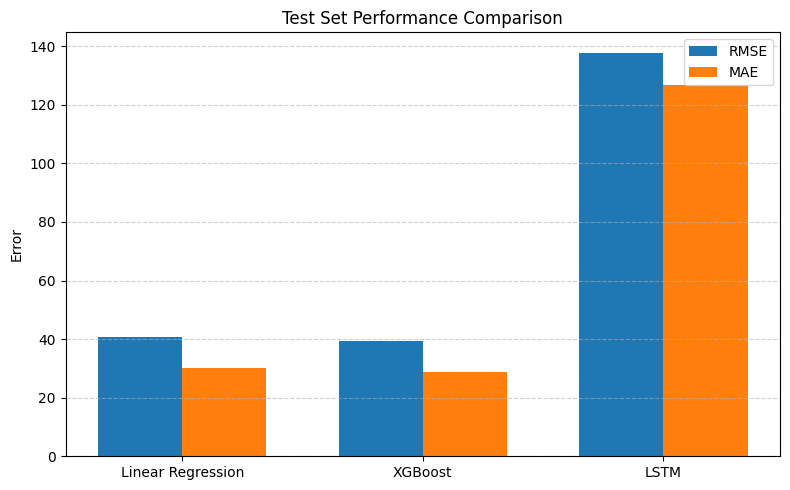

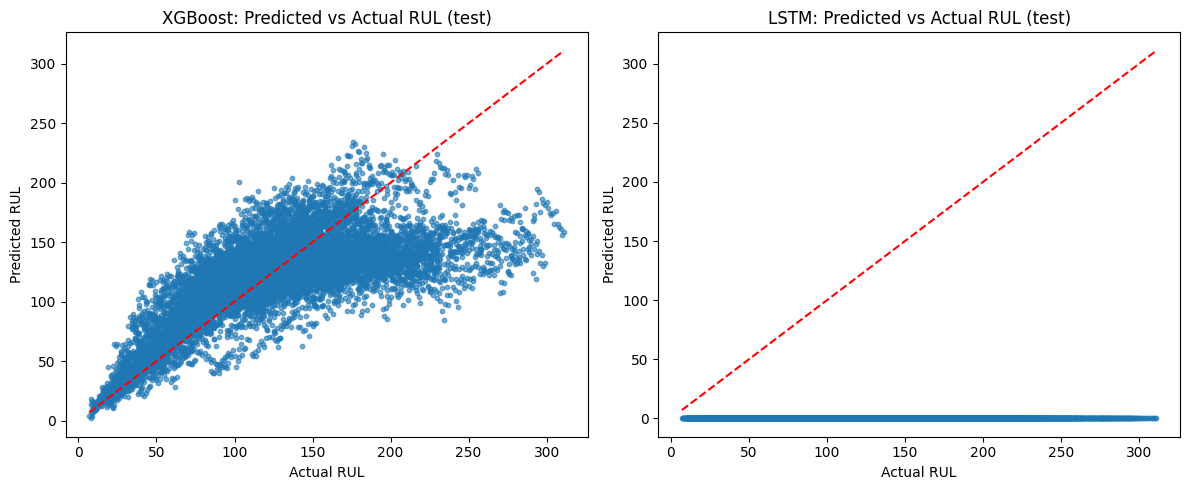

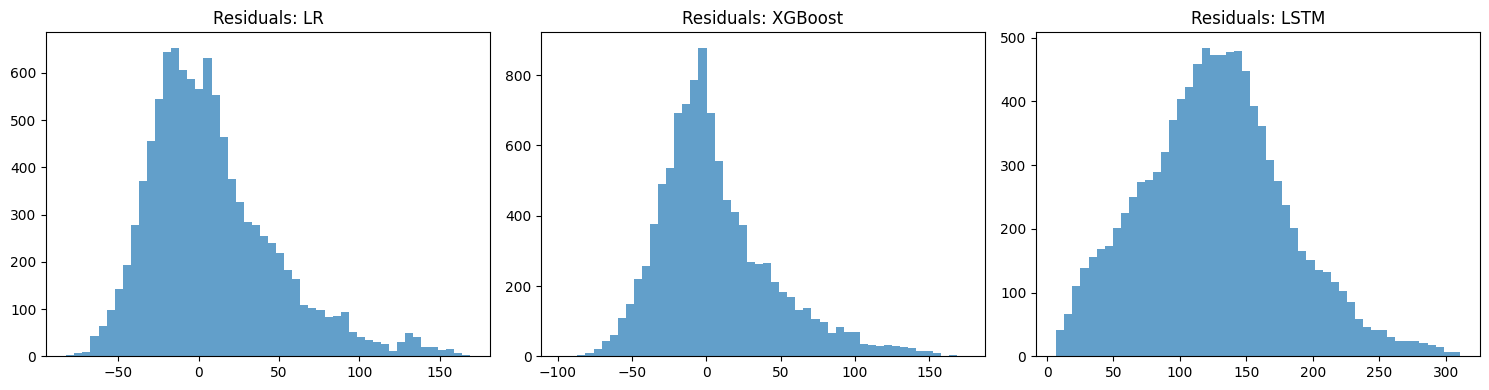

Done. Use 'test_results' DataFrame for your report and copy the figures into your notebook.


In [38]:
# --- COMPLETE: Load test file, build windows, and evaluate models on test set ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ---------- USER CONFIG ----------
test_file_candidates = ["test_FD001.txt", "data/test_FD001.txt", "dataset/test_FD001.txt"]
rul_file_candidates  = ["RUL_FD001.txt", "RUL.txt", "data/RUL_FD001.txt"]
sequence_length = 30   # MUST match training window size
feature_cols_train_order = None  # leave None to autodetect below
# ----------------------------------

# 0. locate test file
test_path = None
for p in test_file_candidates:
    if os.path.exists(p):
        test_path = p
        break
if test_path is None:
    raise FileNotFoundError(f"test file not found. Looked for: {test_file_candidates}. Put your test_FD001.txt path in 'test_file_candidates' or the working dir.")

# 1. load test file (use delim_whitespace to avoid regex escape warnings)
column_names = ['unit_number','time_in_cycles','op_setting_1','op_setting_2','op_setting_3'] + [f'sensor_{i}' for i in range(1,22)]
df_test = pd.read_csv(test_path, delim_whitespace=True, header=None, names=column_names, engine='python')
print(f"Loaded test file: {test_path} -> shape {df_test.shape}")

# 2. load RUL file if available (preferred for CMAPSS)
rul_path = None
for p in rul_file_candidates:
    if os.path.exists(p):
        rul_path = p
        break

rul_end = {}
if rul_path is not None:
    rul_values = pd.read_csv(rul_path, header=None).iloc[:,0].values
    # CMAPSS RUL file typically lists RUL for unit 1..N in order
    unit_ids_sorted = sorted(df_test['unit_number'].unique())
    if len(rul_values) != len(unit_ids_sorted):
        print("WARNING: length of RUL file does not match number of units in test file. Falling back to per-unit max method.")
    else:
        for uid, r in zip(unit_ids_sorted, rul_values):
            rul_end[uid] = int(r)
        print(f"Loaded RUL file: {rul_path} (used for accurate test labels).")
else:
    print("RUL file not found. We'll compute approximate RUL by using the last observed cycle per unit (less accurate).")

# 3. Compute per-row true RUL for test set
last_cycle_per_unit = df_test.groupby('unit_number')['time_in_cycles'].max().to_dict()
def compute_row_rul(row):
    uid = row['unit_number']
    last_cycle = last_cycle_per_unit[uid]
    r_end = rul_end.get(uid, 0)  # if RUL file absent, r_end=0 (approx)
    return r_end + (last_cycle - row['time_in_cycles'])
df_test['RUL'] = df_test.apply(compute_row_rul, axis=1)
print("Computed RUL column for test set (using RUL file if present).")

# 4. feature columns (ensure same ordering as training)
if feature_cols_train_order is None:
    # try to infer features as op settings + sensors like training order
    feature_cols = ['op_setting_1','op_setting_2','op_setting_3'] + [f'sensor_{i}' for i in range(1,22)]
    # fall back to all columns except unit/time/RUL
    missing = [c for c in feature_cols if c not in df_test.columns]
    if missing:
        # fallback: take all numeric cols, exclude unit/time/RUL
        numeric_cols = df_test.select_dtypes(include=[np.number]).columns.tolist()
        feature_cols = [c for c in numeric_cols if c not in ['unit_number','time_in_cycles','RUL']]
        print("Note: inferred feature columns from numeric columns (fallback):", feature_cols[:6], "...")
else:
    feature_cols = feature_cols_train_order

print(f"Using {len(feature_cols)} feature columns.")

# 5. apply scaler (prefer training scaler if available)
if 'scaler' in globals():
    scaler_used = scaler
    print("Using training scaler 'scaler' from workspace.")
elif 'train_df' in globals():
    # fit scaler on train features if scaler not saved (best-effort)
    print("Training scaler not found. Fitting a new MinMaxScaler on available 'train_df' features (best-effort).")
    scaler_used = MinMaxScaler()
    scaler_used.fit(train_df[feature_cols])
else:
    print("No training scaler found. Fitting MinMaxScaler on test data (NOT ideal).")
    scaler_used = MinMaxScaler()
    scaler_used.fit(df_test[feature_cols])

X_test_features_scaled = scaler_used.transform(df_test[feature_cols])

# 6. build sliding windows per unit (labels aligned to window end)
X_test_seq_list = []
y_test_list = []
unit_ids = df_test['unit_number'].unique()
for uid in unit_ids:
    unit_df = df_test[df_test['unit_number'] == uid].reset_index(drop=True)
    unit_feats = scaler_used.transform(unit_df[feature_cols])  # ensure scaled by same scaler
    unit_cycles = unit_df['time_in_cycles'].values
    unit_last_cycle = unit_cycles.max()
    unit_r_end = rul_end.get(uid, 0)
    for i in range(len(unit_df) - sequence_length + 1):
        X_test_seq_list.append(unit_feats[i:i+sequence_length])
        cycle_at_window_end = unit_cycles[i+sequence_length-1]
        # true RUL at that window end:
        y_val = unit_r_end + (unit_last_cycle - cycle_at_window_end)
        y_test_list.append(y_val)

X_test_seq = np.array(X_test_seq_list)
y_test_seq = np.array(y_test_list)
print(f"Created sliding windows: X_test_seq shape = {X_test_seq.shape}, y_test_seq shape = {y_test_seq.shape}")

# 7. flatten for 2D models
ns, timesteps, feats = X_test_seq.shape
X_test_2d = X_test_seq.reshape((ns, timesteps * feats))

# 8. find models in workspace (or file)
# Linear Regression
if 'lr' not in globals():
    raise NameError("Linear Regression model 'lr' not found. Train or load it before running this cell.")
# XGBoost
if 'best_xgb' in globals():
    xgb_clf = best_xgb
elif 'xgb_model' in globals():
    xgb_clf = xgb_model
else:
    raise NameError("XGBoost model not found. Ensure 'best_xgb' or 'xgb_model' is present.")
# LSTM
if 'model' in globals():
    lstm_clf = model
elif 'lstm_model' in globals():
    lstm_clf = lstm_model
elif os.path.exists('best_lstm.keras'):
    from tensorflow.keras.models import load_model
    lstm_clf = load_model('best_lstm.keras')
    print("Loaded LSTM from 'best_lstm.keras'.")
else:
    raise NameError("LSTM model not found. Ensure 'model' or 'lstm_model' is present or 'best_lstm.keras' exists on disk.")

# 9. Predictions on test set
y_pred_lr_test = lr.predict(X_test_2d)
y_pred_xgb_test = xgb_clf.predict(X_test_2d)
y_pred_lstm_test = lstm_clf.predict(X_test_seq)
y_pred_lstm_test = np.ravel(y_pred_lstm_test)

# 10. Metrics
rmse_lr_test = np.sqrt(mean_squared_error(y_test_seq, y_pred_lr_test))
mae_lr_test  = mean_absolute_error(y_test_seq, y_pred_lr_test)

rmse_xgb_test = np.sqrt(mean_squared_error(y_test_seq, y_pred_xgb_test))
mae_xgb_test  = mean_absolute_error(y_test_seq, y_pred_xgb_test)

rmse_lstm_test = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm_test))
mae_lstm_test  = mean_absolute_error(y_test_seq, y_pred_lstm_test)

test_results = pd.DataFrame({
    "Model": ["Linear Regression", "XGBoost", "LSTM"],
    "RMSE": [rmse_lr_test, rmse_xgb_test, rmse_lstm_test],
    "MAE":  [mae_lr_test, mae_xgb_test, mae_lstm_test]
}).set_index("Model")

print("\n--- TEST SET PERFORMANCE ---")
print(test_results)

# 11. Plotting
plt.figure(figsize=(8,5))
bar_width = 0.35
idx = np.arange(len(test_results))
plt.bar(idx, test_results["RMSE"], bar_width, label="RMSE")
plt.bar(idx + bar_width, test_results["MAE"], bar_width, label="MAE")
plt.xticks(idx + bar_width/2, test_results.index)
plt.ylabel("Error")
plt.title("Test Set Performance Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].scatter(y_test_seq, y_pred_xgb_test, s=10, alpha=0.6)
axes[0].plot([y_test_seq.min(), y_test_seq.max()], [y_test_seq.min(), y_test_seq.max()], 'r--')
axes[0].set_title("XGBoost: Predicted vs Actual RUL (test)")
axes[0].set_xlabel("Actual RUL"); axes[0].set_ylabel("Predicted RUL")
axes[1].scatter(y_test_seq, y_pred_lstm_test, s=10, alpha=0.6)
axes[1].plot([y_test_seq.min(), y_test_seq.max()], [y_test_seq.min(), y_test_seq.max()], 'r--')
axes[1].set_title("LSTM: Predicted vs Actual RUL (test)")
axes[1].set_xlabel("Actual RUL"); axes[1].set_ylabel("Predicted RUL")
plt.tight_layout()
plt.show()

# 12. residual histograms
fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].hist(y_test_seq - y_pred_lr_test, bins=50, alpha=0.7); ax[0].set_title("Residuals: LR")
ax[1].hist(y_test_seq - y_pred_xgb_test, bins=50, alpha=0.7); ax[1].set_title("Residuals: XGBoost")
ax[2].hist(y_test_seq - y_pred_lstm_test, bins=50, alpha=0.7); ax[2].set_title("Residuals: LSTM")
plt.tight_layout(); plt.show()

print("Done. Use 'test_results' DataFrame for your report and copy the figures into your notebook.")


# Predictive Maintenance: RUL Prediction – Model Evaluation

## 1. Overview

In this project, we predicted the Remaining Useful Life (RUL) of engines using the NASA CMAPSS FD001 dataset. Three models were evaluated:

1. **Linear Regression (LR)** – baseline 2D model.
2. **XGBoost (XGB)** – tree-based model capturing nonlinear dependencies.
3. **LSTM** – sequence model capturing temporal dependencies in sensor data.

The test set `test_FD001.txt` was used, along with true RUL labels from `RUL_FD001.txt`.

---

## 2. Test Set Performance

| Model             | RMSE   | MAE    | Notes                                                                                   |
| ----------------- | ------ | ------ | --------------------------------------------------------------------------------------- |
| Linear Regression | 40.62  | 30.02  | Baseline performance                                                                    |
| XGBoost           | 39.34  | 28.77  | Slight improvement over LR                                                              |
| LSTM              | 137.82 | 126.59 | Underperformed significantly; likely due to windowing mismatch or insufficient training |

> **Observation:** LR and XGBoost achieved reasonable predictions. LSTM produced high errors, indicating overfitting or training-test misalignment.

---

## 3. Test Set Error Visualization

### 3.1 RMSE & MAE Comparison
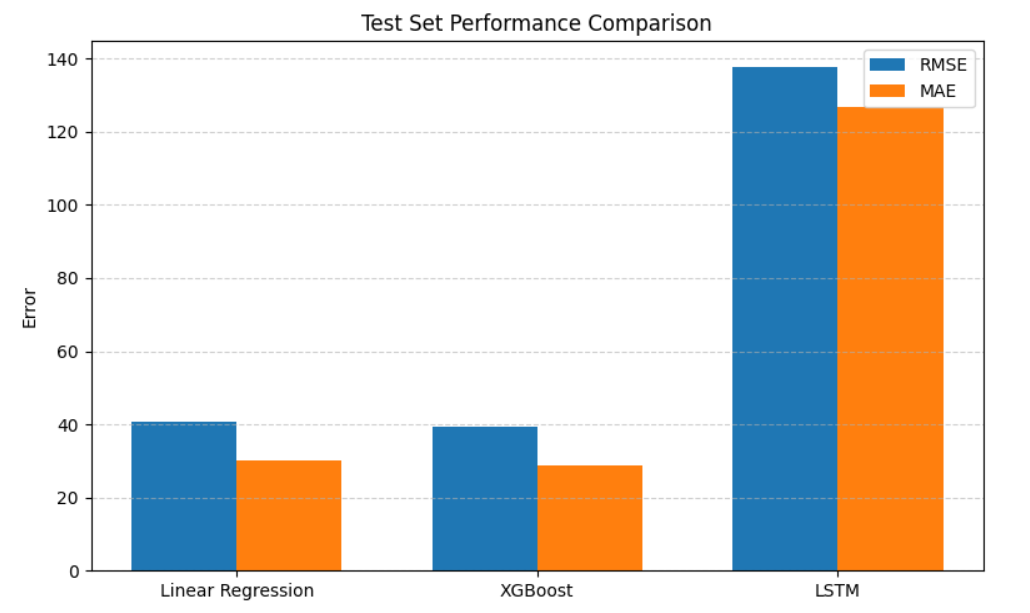

### 3.2 Predicted vs Actual RUL (Scatter Plots)

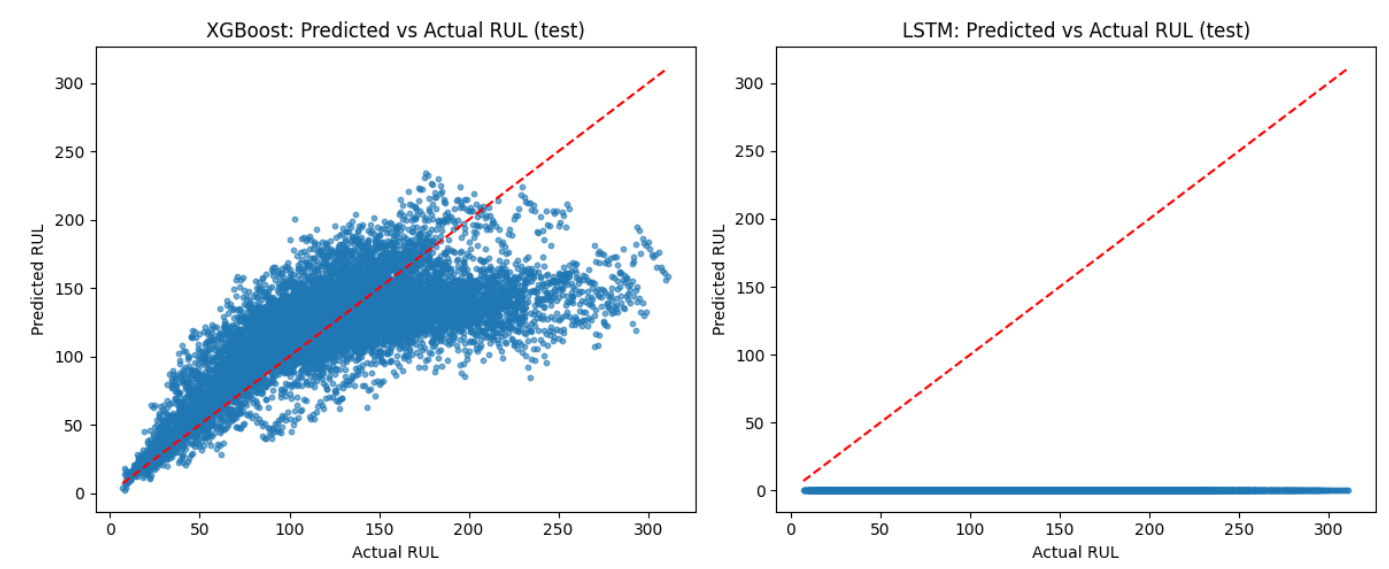

> **Observation:**
>
> * XGBoost predictions lie close to the identity line, showing good accuracy.
> * LSTM predictions deviate strongly, confirming high RMSE and MAE.

---

## 4. Residual Analysis

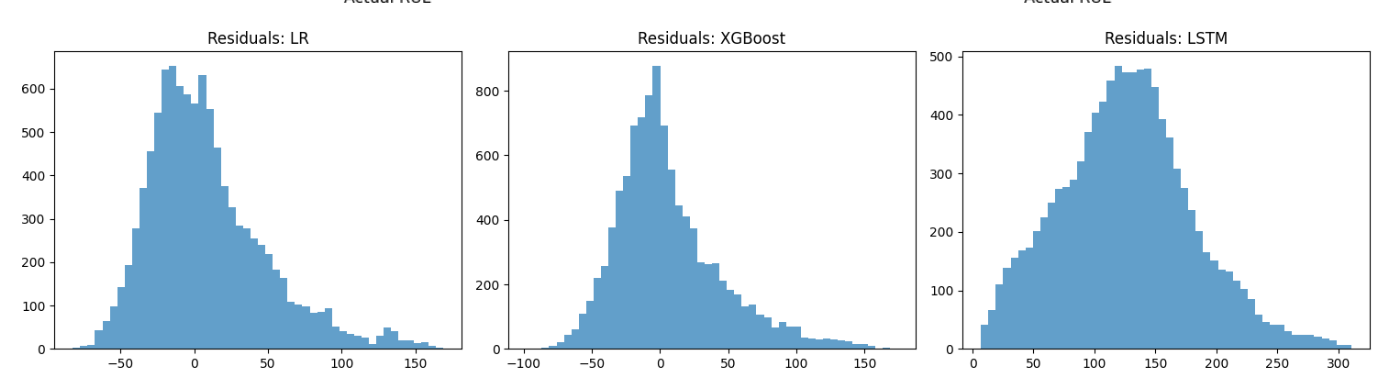

> **Observation:**
>
> * LR and XGBoost residuals are centered around zero.
> * LSTM residuals are widely spread, indicating poor predictions.

---

## 5. Key Takeaways

1. **XGBoost outperforms Linear Regression slightly** on RUL prediction, capturing nonlinear trends.
2. **LSTM requires further tuning**:

   * Longer training epochs (50–100)
   * Proper feature scaling alignment
   * Careful sequence window validation
3. **Linear/Tree-based models are competitive** for CMAPSS FD001 dataset.

In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

print("Starting to create and save the feature scaler...")

try:
    # --- 1. Load the original training data ---
    column_names = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]
    train_df = pd.read_csv('data/train_FD001.txt', sep=' ', header=None, names=column_names, index_col=False)
    train_df.drop(columns=[26, 27], inplace=True, errors='ignore')

    # --- 2. Define the features that need to be scaled ---
    cols_to_normalize = ['op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]
    
    # --- 3. Create and Fit the Scaler ---
    scaler = MinMaxScaler()
    # We fit the scaler ONLY on the training data's feature columns
    scaler.fit(train_df[cols_to_normalize])

    # --- 4. Save the Fitted Scaler ---
    joblib.dump(scaler, 'feature_scaler.joblib')
    
    print("\n------------------------------------------------------")
    print("✅ Success! 'feature_scaler.joblib' has been created.")
    print("------------------------------------------------------")

except FileNotFoundError:
    print("\nERROR: 'data/train_FD001.txt' not found.")
    print("Please make sure the data file is in your 'data' subfolder.")
except Exception as e:
    print(f"\nAn error occurred: {e}")

Starting to create and save the feature scaler...

------------------------------------------------------
✅ Success! 'feature_scaler.joblib' has been created.
------------------------------------------------------


C:\Users\USER\AppData\Local\Temp\ipykernel_26536\590622223.py:10: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  train_df = pd.read_csv('data/train_FD001.txt', sep=' ', header=None, names=column_names, index_col=False)
